In [22]:
%pip install matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

Note: you may need to restart the kernel to use updated packages.


In [2]:
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x = torch.randn( (batch_size, sequence_length, input_dim) )


In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
# q: What I am looking for 
# k: what can I offer
# v: What I actually offer
qkv_layer = nn.Linear(input_dim , 3 * d_model)


In [6]:
qkv=qkv_layer(x)

In [8]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

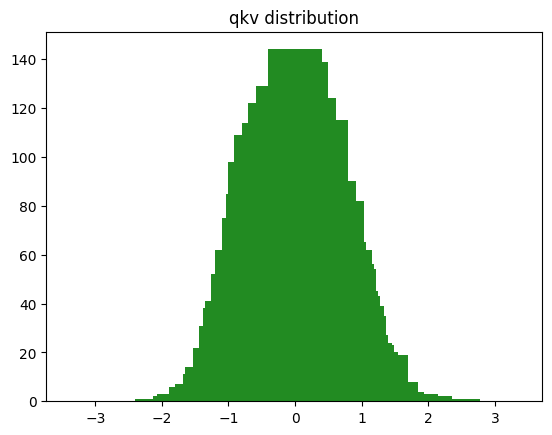

In [12]:
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [17]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [18]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [19]:
q, k, v = qkv.chunk(3, dim=-1)# to break the qkv vector into into its individual vector
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self Attention for multiple heads
For a single Head:

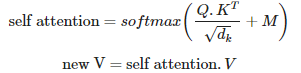

In [23]:
# Implementing self Attention:-
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [25]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [27]:
(scaled + mask)[0][0]

tensor([[ 0.0672,    -inf,    -inf,    -inf],
        [-0.3336,  0.1988,    -inf,    -inf],
        [-0.1812,  0.1981,  0.1414,    -inf],
        [-0.5908, -0.1660, -0.1648, -0.3144]], grad_fn=<SelectBackward0>)

In [28]:
scaled+=mask

In [36]:
np.exp(0.1988)/(np.exp(0.1988)+np.exp(-0.3144))


0.6255563290516698

In [37]:
attention = F.softmax(scaled, dim=-1)

In [38]:
attention.shape

torch.Size([1, 8, 4, 4])

In [39]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3700, 0.6300, 0.0000, 0.0000],
        [0.2603, 0.3803, 0.3594, 0.0000],
        [0.1859, 0.2843, 0.2847, 0.2451]], grad_fn=<SelectBackward0>)

In [40]:
values=torch.matmul(attention,v)

In [41]:
values.shape

torch.Size([1, 8, 4, 64])

# Function

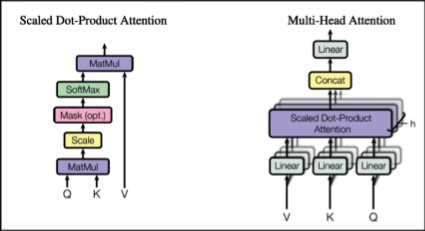

In [43]:
def scaled_dot_product(q,k,v, mask=None):
    d_k=q.size()[-1]
    scaled=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=-1)
    values=torch.matmul(attention,v)
    return values,attention

In [44]:
values,attention=scaled_dot_product(q,k,v,mask=mask)
attention.shape

torch.Size([1, 8, 4, 4])

In [46]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3700, 0.6300, 0.0000, 0.0000],
        [0.2603, 0.3803, 0.3594, 0.0000],
        [0.1859, 0.2843, 0.2847, 0.2451]], grad_fn=<SelectBackward0>)

In [47]:
values.size()

torch.Size([1, 8, 4, 64])

In [48]:
values=values.reshape(batch_size,sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [49]:
liner_layer=nn.Linear(d_model,d_model)

In [50]:
out=liner_layer(values)

In [52]:
out.shape

torch.Size([1, 4, 512])

In [53]:
out

tensor([[[-0.0670, -0.4626, -0.0749,  ..., -0.2191,  0.2445, -0.0090],
         [ 0.1132, -0.2171, -0.0149,  ...,  0.3013, -0.1907,  0.2636],
         [ 0.2734,  0.1744,  0.1520,  ..., -0.1840, -0.3003,  0.3072],
         [-0.0232,  0.3789, -0.0063,  ...,  0.1986,  0.1698, -0.4789]]],
       grad_fn=<ViewBackward0>)